In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=out_channels,out_channels=out_channels,
                      kernel_size=1, stride=1, bias=False))
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers = 2):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([ResidualBlock(256, 256)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)
    
class Encoder(nn.Module):
    def __init__(self, embbeding_dim = 2, in_ch = 3):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, 128, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.residual = ResidualStack(256, 256)
        self.pre_vq_conv = nn.Conv2d(256, embbeding_dim, kernel_size=1, stride=1)
#         self.residual2 = ResidualBlock(256, 256)
#         self.fc = nn.Linear(256, codebook_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        x = self.residual(x)
        x = self.pre_vq_conv(x)
        return x

class Decoder(nn.Module):
    def __init__(self, embbeding_dim = 2, in_ch=3):
        super(Decoder, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=embbeding_dim, out_channels=256, kernel_size=3,stride=1, padding=1)
        self.residual = ResidualStack(256, 256)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, in_ch, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.residual(x)
        x = F.relu(self.deconv1(x))
        x = self.deconv2(x)
        return x

    
class VectorQuantizer(nn.Module):
    def __init__(self, n_e = 3, e_dim = 2, beta = 0.25, ema_decay=0.99, epsilon=1e-5):
        super(VectorQuantizer, self).__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta
        self.ema_decay = ema_decay
        self.epsilon = epsilon

        # Initialize the codebook with three 2-dimensional vectors
        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.normal_()
        
        self.register_buffer('N', torch.zeros(n_e))
        self.ema_w = nn.Parameter(torch.Tensor(n_e, self.e_dim))
        self.ema_w.data.normal_()
        
#         self.embedding = nn.Parameter(torch.rand(n_e, e_dim))
#         self.register_buffer('N', torch.zeros(n_e))
#         self.register_buffer('m', torch.zeros((n_e, e_dim)))

    def forward(self, z):
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.e_dim)

        distance = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1) - 2 * torch.matmul(z_flattened, self.embedding.weight.t())
        encoding_indices = torch.argmin(distance, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.n_e, device=z.device)
        encodings.scatter_(1, encoding_indices, 1)

        z_q = torch.matmul(encodings, self.embedding.weight).view(z.shape)
        if self.training:
            # Compute EMA updates
            self.N = self.N* self.ema_decay + (1.0 - self.ema_decay) * encodings.sum(dim=0)
            n = torch.sum(self.N.data)
            self.N = ((self.N + self.epsilon)/ (n + self.n_e * self.epsilon) * n)
            dw = torch.matmul(encodings.t(), z_flattened)
            self.ema_w = nn.Parameter(self.ema_w * self.ema_decay + (1 - self.ema_decay) * dw)
            self.embedding.weight = nn.Parameter(self.ema_w / self.N.unsqueeze(1))

    #         self.m *= self.ema_decay
    #         self.m += (1.0 - self.ema_decay) * torch.matmul(encodings.t(), z_flattened)
    #         e_tilde = self.m / self.N.unsqueeze(1)
            # Update the codebook
    #         self.embedding.data = e_tilde.detach()

        # Calculate loss
        e_latent_loss = F.mse_loss(z_q.detach(), z)
        loss = self.beta * e_latent_loss
#         q_latent_loss = F.mse_loss(z_q, z.detach())
#         loss = q_latent_loss + self.beta * e_latent_loss
#         loss = torch.mean((z_q.detach() - z)**2) + self.beta * torch.mean((z_q - z.detach())**2)

        # Preserve gradients
        z_q = z + (z_q - z).detach()
        e_mean = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))
        z_q = z_q.permute(0, 3, 1, 2).contiguous()

        return loss, z_q, perplexity, encodings

    
class VQVAE(nn.Module):
    def __init__(self, codebook_size=3, codebook_dim=2, beta=0.25, ema_decay=0.99, in_ch = 3):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(codebook_dim,in_ch)
        self.decoder = Decoder(codebook_dim,in_ch)
        self.vector_quantizer = VectorQuantizer(codebook_size, codebook_dim, beta, ema_decay)

    def forward(self, x):
        z_e = self.encoder(x)
        loss, z_q, perplexity, _ = self.vector_quantizer(z_e)
        x_recon = self.decoder(z_q)

        return x_recon, loss, perplexity


In [18]:
# Training the VQ-VAE with the provided loss function
def train_vqvae(model, dataloader, num_epochs=10, lr=0.001, num_updates_per_epoch=200):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # Lists to store codebook vectors and losses for visualization
    codebook_vectors = []
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_codebook_vectors = []
        for update in range(num_updates_per_epoch):  # Adjust the number of updates per epoch here
            data, _ = next(iter(dataloader))  # Only for illustration, you might need to modify this based on your actual data loading
            data = data.to(device)
            
#         for data, _ in dataloader:
#             data = data.to(device)

            optimizer.zero_grad()

            recon, vq_loss, perplexity = model(data)
            recon_error = F.mse_loss(recon, data)
            total_loss = recon_error + vq_loss
            codebook_vector = model.vector_quantizer.embedding.weight.cpu().detach().numpy()
            epoch_codebook_vectors.append(codebook_vector)
            
            total_loss.backward()
            optimizer.step()
            epoch_loss += total_loss.item()
        
        codebook_vectors.append(epoch_codebook_vectors)
#         average_epoch_loss = epoch_loss / len(dataloader)
        average_epoch_loss = epoch_loss / num_updates_per_epoch 
        
#         Append codebook vectors and losses for visualization
#         codebook_vectors.append(model.vector_quantizer.embedding.weight.clone().detach())
        losses.append(average_epoch_loss)
        # Print or log the average loss for the epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_epoch_loss}, Perplexity: {perplexity.item()}")

    return losses , model, codebook_vectors


In [42]:
# Assuming you have a DataLoader for MNIST called 'train_dataloader'
batch_size = 128
# MNIST DataLoader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
# Define the train & test dataSets
train_set = datasets.MNIST(root='./data', train=True,
                           download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False,
                          download=True, transform=transform)

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

vqvae_model = VQVAE(in_ch = 1)
out_losses, final_model , final_codebook_vector = train_vqvae(vqvae_model, train_dataloader)


Epoch 1/10, Average Loss: 0.6214654985070228, Perplexity: 1.0
Epoch 2/10, Average Loss: 0.6816868469119072, Perplexity: 1.0
Epoch 3/10, Average Loss: 0.24069442842155694, Perplexity: 2.817392110824585
Epoch 4/10, Average Loss: 0.09481265950948, Perplexity: 2.8634610176086426
Epoch 5/10, Average Loss: 0.08502032559365034, Perplexity: 2.8958725929260254
Epoch 6/10, Average Loss: 0.08016806732863188, Perplexity: 2.904959201812744
Epoch 7/10, Average Loss: 0.07780569106340408, Perplexity: 2.919948101043701
Epoch 8/10, Average Loss: 0.07514457389712334, Perplexity: 2.916252851486206
Epoch 9/10, Average Loss: 0.07329191241413355, Perplexity: 2.8967294692993164
Epoch 10/10, Average Loss: 0.07196551725268364, Perplexity: 2.9373953342437744


In [11]:
def visualize_resultss(inp_model, dataloader, losses, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inp_model.to(device)
    inp_model.eval()

    for samples, _ in dataloader:
        samples = samples.to(device)

        with torch.no_grad():
            reconstructed, _, _ = inp_model(samples)

    # Visualize some input-output pairs
    visualize_samples(samples, reconstructed, num_samples)

    # Plot the training losses
    plot_losses(losses)
    visualize_codebook_vectors(inp_model)

def visualize_samples(inputs, outputs, num_samples):
    inputs = inputs.cpu().numpy()
    outputs = outputs.cpu().numpy()

    plt.figure(figsize=(10, 4))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(inputs[i, 0])
        plt.axis('off')
        plt.title('Input')

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(outputs[i, 0])
        plt.axis('off')
        plt.title('Output')

    plt.show()

def plot_losses(losses):
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Average Loss")
    plt.show()

    
def visualize_codebook_vectors(model):
    codebook_vectors = model.vector_quantizer.embedding.weight.data.cpu().numpy()

    plt.figure(figsize=(6, 6))
    plt.scatter(codebook_vectors[:, 0], codebook_vectors[:, 1], label="Codebook Vectors", color='red')

    for i, (x, y) in enumerate(codebook_vectors):
        plt.text(x, y, f'{i}', fontsize=8, ha='right', va='bottom')

    plt.title("Codebook Vectors")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.show()
    

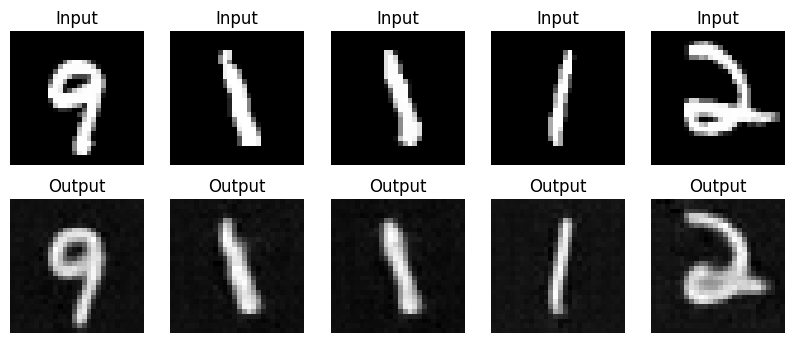

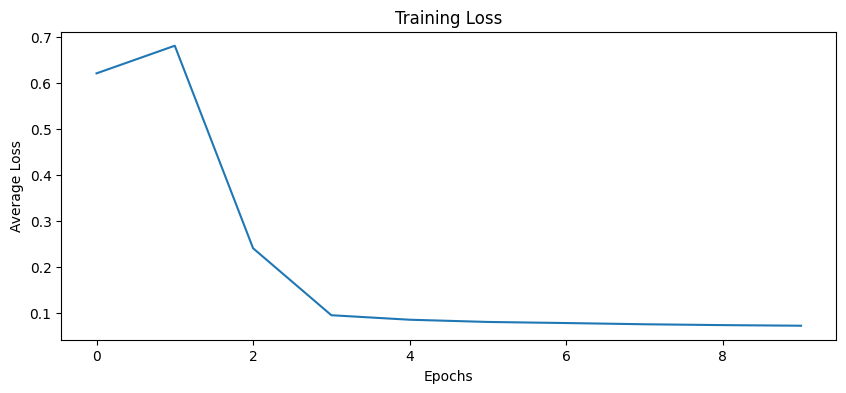

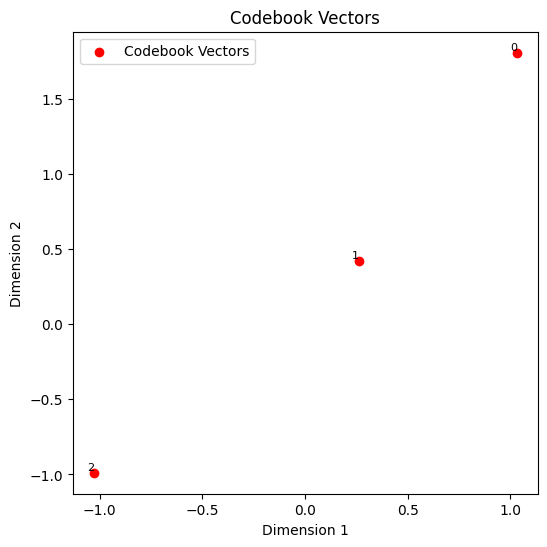

In [44]:
visualize_resultss(final_model, test_dataloader, out_losses)


## 3 Channel Mnist

In [57]:
from torch.utils.data import Dataset, DataLoader
num_workers = 2
class MNIST3ChannelRandomDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.num_samples = len(self.mnist_dataset)
        self.random_numbers = torch.rand((self.num_samples, 3))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]

        # Generate 3 random numbers between (0, 1)
        random_values = self.random_numbers[idx]

        # Duplicate the single channel to form 3 channels
        image_3channel = torch.cat([image, image, image], dim=0)

        # Assign random values to each channel
        image_3channel[0, :, :] *= random_values[0]
        image_3channel[1, :, :] *= random_values[1]
        image_3channel[2, :, :] *= random_values[2]

        # Normalize the pixel values to be in the range (0, 1)
        image_3channel = (image_3channel + 1) / 2.0

        return image_3channel, label

# MNIST DataLoader with 3 channels and random values
transform_3channel_random = transforms.Compose([
    transforms.ToTensor()
])

# Define train and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_3channel_random)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_3channel_random)

# Create instances of the custom dataset
train_random_3channel_dataset = MNIST3ChannelRandomDataset(train_dataset)
test_random_3channel_dataset = MNIST3ChannelRandomDataset(test_dataset)


# Create train and test dataloaders
train_dataloader_rgb = DataLoader(train_random_3channel_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader_rgb = DataLoader(test_random_3channel_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

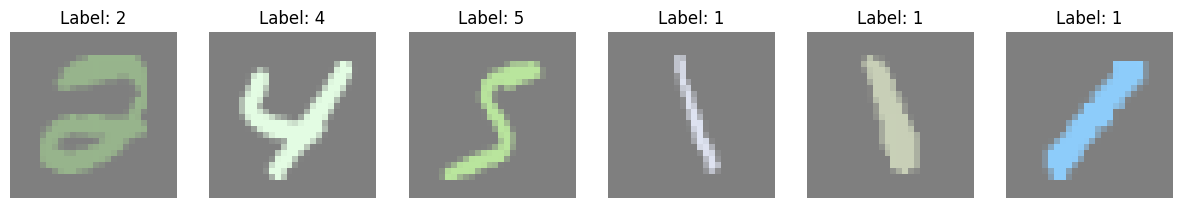

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images
def show_images(images, labels, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        image = images[i].numpy().transpose((1, 2, 0))
        label = labels[i]

        axes[i].imshow(image)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')

    plt.show()

# Get 6 random samples from the train_random_3channel_dataset
indices = torch.randint(0, len(train_random_3channel_dataset), (6,))
sample_images, sample_labels = zip(*[train_random_3channel_dataset[i] for i in indices])
# Display the images
show_images(sample_images, sample_labels)

In [47]:
vqvae_model = VQVAE(in_ch = 3)
out_losses, final_model , final_codebook_vector = train_vqvae(vqvae_model, train_dataloader_rgb)


Epoch 1/10, Average Loss: 0.019926558677107097, Perplexity: 1.0


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/conda/lib/python3.10/shutil.py", line 731, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/conda/lib/python3.10/shutil.py", line 729, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-qtwfz3qy'


Epoch 2/10, Average Loss: 0.007290374787990004, Perplexity: 1.0
Epoch 3/10, Average Loss: 0.0074038663553074, Perplexity: 1.0
Epoch 4/10, Average Loss: 0.006124716375488788, Perplexity: 2.0980162620544434
Epoch 5/10, Average Loss: 0.003917243753094226, Perplexity: 2.4452662467956543
Epoch 6/10, Average Loss: 0.0036269456753507258, Perplexity: 2.51054310798645
Epoch 7/10, Average Loss: 0.003494594725780189, Perplexity: 2.5065207481384277
Epoch 8/10, Average Loss: 0.003486463479930535, Perplexity: 2.6126348972320557
Epoch 9/10, Average Loss: 0.003298464484978467, Perplexity: 2.6490185260772705
Epoch 10/10, Average Loss: 0.0031536953046452255, Perplexity: 2.687713861465454


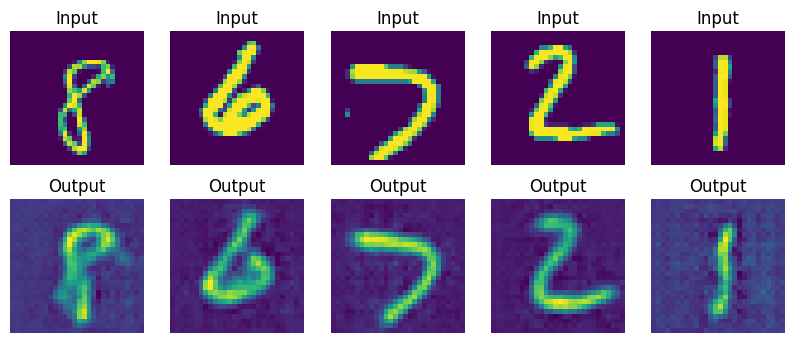

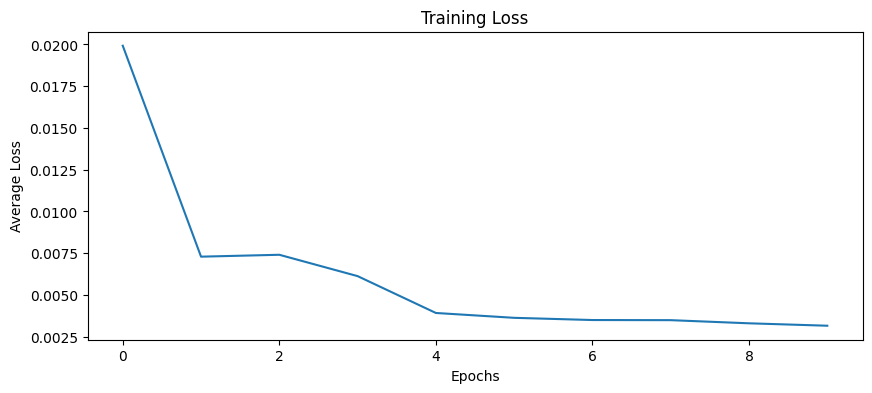

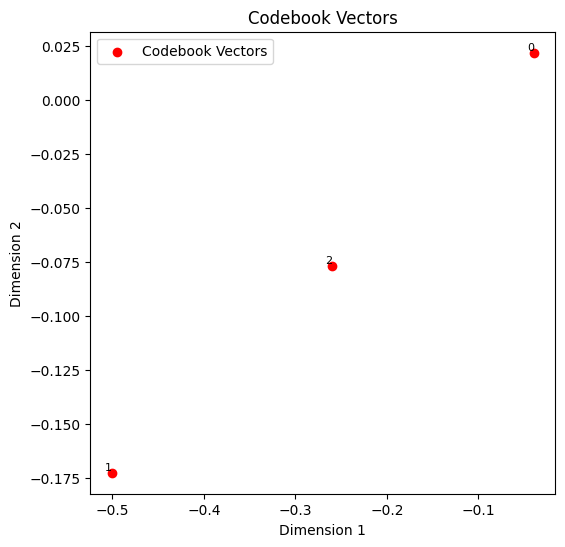

In [58]:
visualize_resultss(final_model, test_dataloader_rgb, out_losses)

## 15 Channel Mnist

In [27]:
from torch.utils.data import Dataset, DataLoader

class MNISTMultiChannelRandomDataset(Dataset):
    def __init__(self, mnist_dataset, num_channels = num_ch):
        self.mnist_dataset = mnist_dataset
        self.num_samples = len(self.mnist_dataset)
        self.num_channels = num_channels
        self.random_numbers = torch.rand((self.num_samples, self.num_channels))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]

        # Generate random numbers between (0, 1) for each channel
        random_values = self.random_numbers[idx]

        # Duplicate the single channel to form multiple channels
        image_multichannel = torch.cat([image] * self.num_channels, dim=0)

        # Assign random values to each channel
        for i, num_channel in enumerate(range(self.num_channels)):
            image_multichannel[i, :, :] *= random_values[i]

        # Normalize the pixel values to be in the range (0, 1)
        image_multichannel = (image_multichannel + 1) / 2.0

        return image_multichannel, label


In [25]:
num_ch = 15

# MNIST DataLoader with multiple channels and random values
transform_multichannel_random = transforms.Compose([
    transforms.ToTensor()
])

# Define train and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_multichannel_random)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_multichannel_random)

# Create instances of the custom dataset with 15, 30, and 50 channels
train_multichannel_dataset = MNISTMultiChannelRandomDataset(train_dataset, num_channels=num_ch)
test_multichannel_dataset = MNISTMultiChannelRandomDataset(test_dataset, num_channels=num_ch)

# Create train and test dataloaders
batch_size = 256
num_workers = 2
train_dataloader_multichannel = DataLoader(train_multichannel_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader_multichannel = DataLoader(test_multichannel_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Epoch 1/10, Average Loss: 0.017096020563039927, Perplexity: 1.0
Epoch 2/10, Average Loss: 0.007140890865121037, Perplexity: 1.0


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/conda/lib/python3.10/shutil.py", line 731, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/conda/lib/python3.10/shutil.py", line 729, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-r_jgwa7a'


Epoch 3/10, Average Loss: 0.007402618052437902, Perplexity: 1.0
Epoch 4/10, Average Loss: 0.007271828143857419, Perplexity: 1.8947023153305054
Epoch 5/10, Average Loss: 0.004380386658012867, Perplexity: 2.9345543384552
Epoch 6/10, Average Loss: 0.0037768032343592495, Perplexity: 2.9321725368499756
Epoch 7/10, Average Loss: 0.0036390916211530566, Perplexity: 2.9658877849578857
Epoch 8/10, Average Loss: 0.003547446558950469, Perplexity: 2.978855848312378
Epoch 9/10, Average Loss: 0.003498282778309658, Perplexity: 2.9653587341308594
Epoch 10/10, Average Loss: 0.003448138243984431, Perplexity: 2.9749138355255127


Exception ignored in: <function _ConnectionBase.__del__ at 0x7f8b50b87e20>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/opt/conda/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


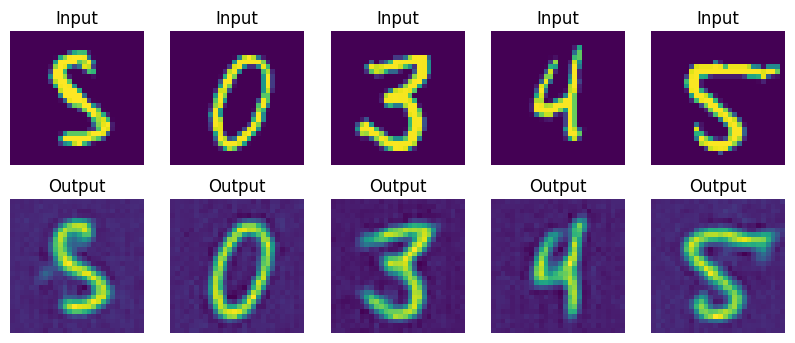

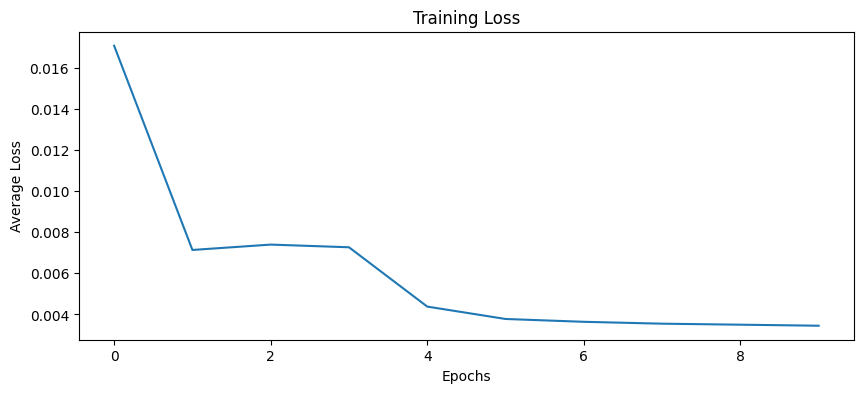

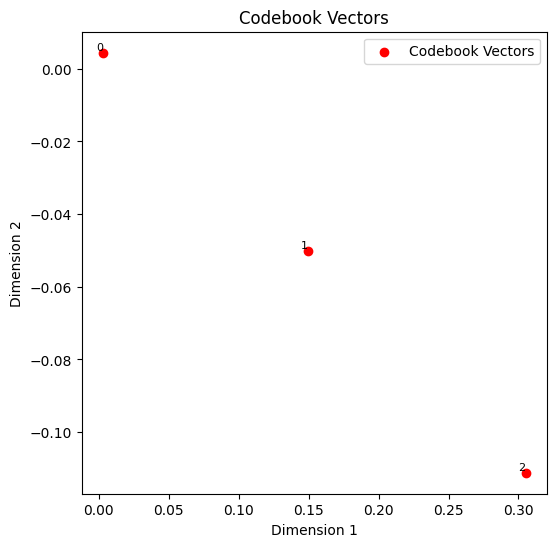

In [26]:
vqvae_model = VQVAE(in_ch = num_ch)
out_losses, final_model , final_codebook_vector = train_vqvae(vqvae_model, train_dataloader_multichannel)
visualize_resultss(final_model, test_dataloader_multichannel, out_losses)


## 30 Channel Mnist

In [28]:
num_ch = 30

# MNIST DataLoader with multiple channels and random values
transform_multichannel_random = transforms.Compose([
    transforms.ToTensor()
])

# Define train and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_multichannel_random)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_multichannel_random)

# Create instances of the custom dataset with 15, 30, and 50 channels
train_multichannel_dataset = MNISTMultiChannelRandomDataset(train_dataset, num_channels=num_ch)
test_multichannel_dataset = MNISTMultiChannelRandomDataset(test_dataset, num_channels=num_ch)

# Create train and test dataloaders
batch_size = 512
num_workers = 2
train_dataloader_multichannel = DataLoader(train_multichannel_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader_multichannel = DataLoader(test_multichannel_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


Epoch 1/5, Average Loss: 0.018403710410930217, Perplexity: 1.0
Epoch 2/5, Average Loss: 0.006644859844818711, Perplexity: 1.0
Epoch 3/5, Average Loss: 0.006592216533608735, Perplexity: 1.0
Epoch 4/5, Average Loss: 0.006591438655741513, Perplexity: 1.0
Epoch 5/5, Average Loss: 0.006557037094607949, Perplexity: 1.0


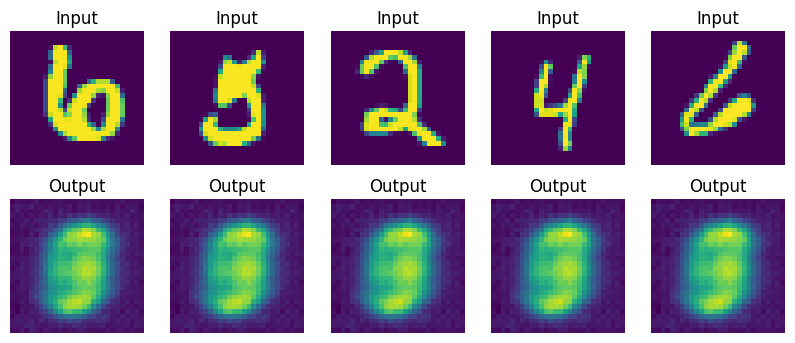

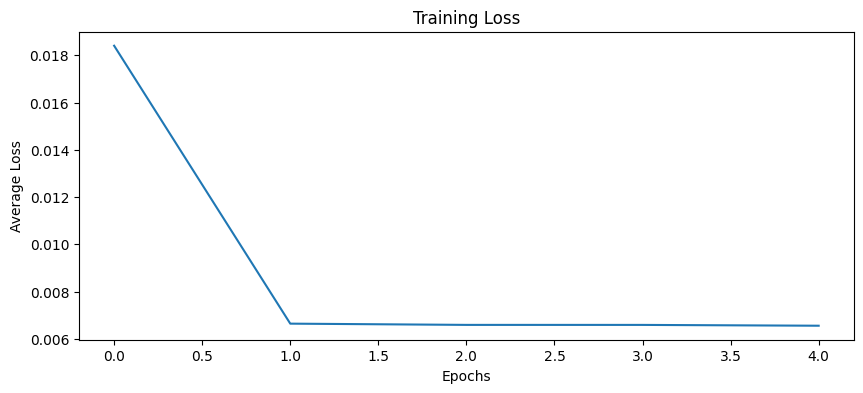

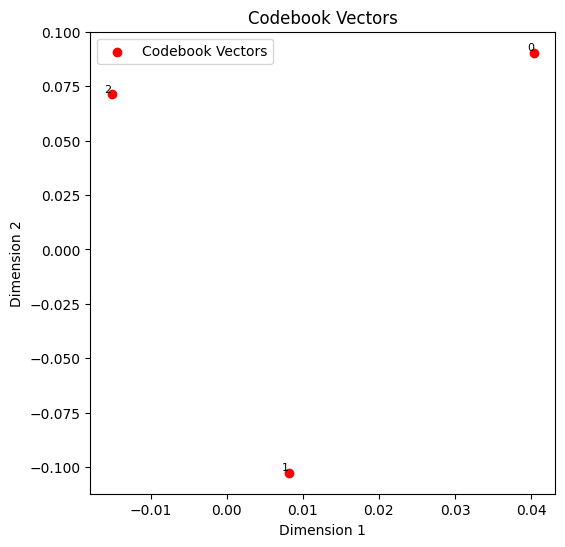

In [29]:
vqvae_model = VQVAE(in_ch = num_ch)
out_losses, final_model , final_codebook_vector = train_vqvae(vqvae_model, train_dataloader_multichannel, num_epochs=5)
visualize_resultss(final_model, test_dataloader_multichannel, out_losses)

In [30]:
num_ch = 50

# MNIST DataLoader with multiple channels and random values
transform_multichannel_random = transforms.Compose([
    transforms.ToTensor()
])

# Define train and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_multichannel_random)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_multichannel_random)

# Create instances of the custom dataset with 15, 30, and 50 channels
train_multichannel_dataset = MNISTMultiChannelRandomDataset(train_dataset, num_channels=num_ch)
test_multichannel_dataset = MNISTMultiChannelRandomDataset(test_dataset, num_channels=num_ch)

# Create train and test dataloaders
batch_size = 512
num_workers = 2
train_dataloader_multichannel = DataLoader(train_multichannel_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader_multichannel = DataLoader(test_multichannel_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


Epoch 1/5, Average Loss: 0.02891777572920546, Perplexity: 1.0
Epoch 2/5, Average Loss: 0.006953962249681354, Perplexity: 1.0
Epoch 3/5, Average Loss: 0.007182027278468013, Perplexity: 1.0
Epoch 4/5, Average Loss: 0.0073032839852385225, Perplexity: 1.0
Epoch 5/5, Average Loss: 0.006107755359262228, Perplexity: 2.8918819427490234


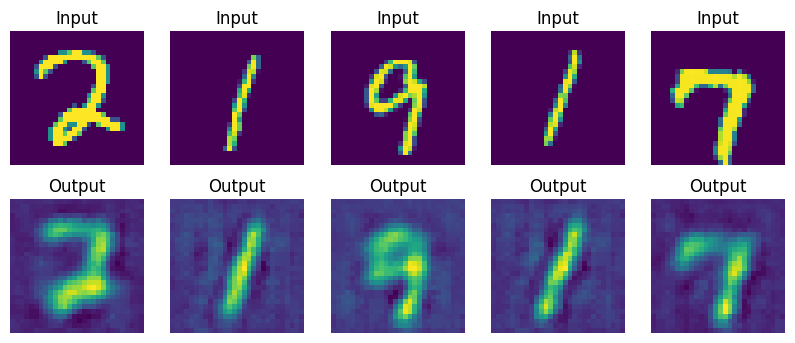

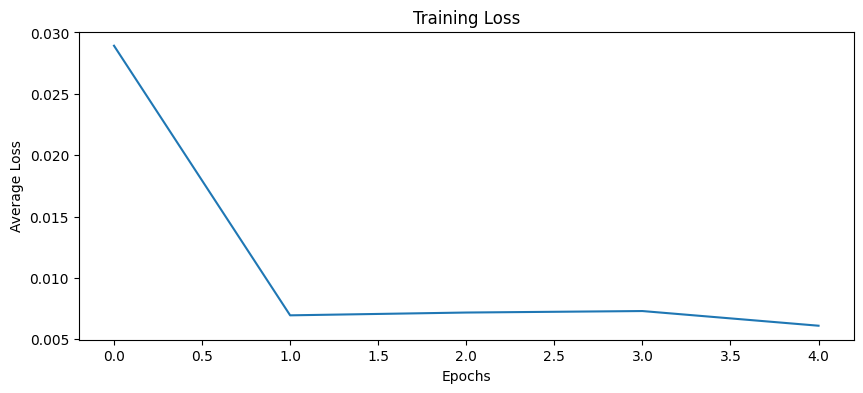

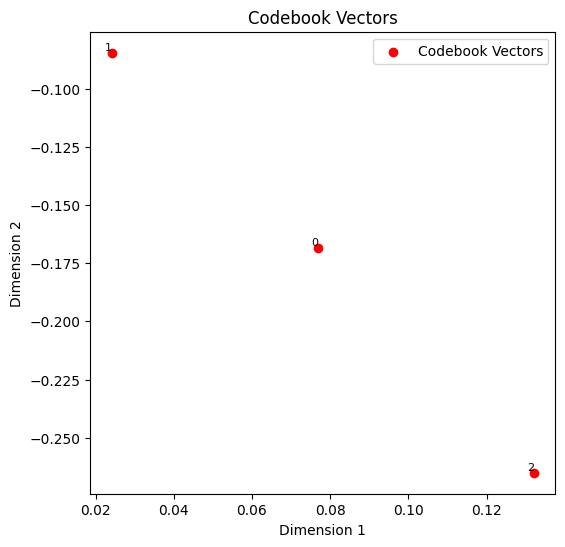

In [31]:
vqvae_model = VQVAE(in_ch = num_ch)
out_losses, final_model , final_codebook_vector = train_vqvae(vqvae_model, train_dataloader_multichannel, num_epochs=5)
visualize_resultss(final_model, test_dataloader_multichannel, out_losses)

In [32]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=out_channels,out_channels=out_channels,
                      kernel_size=1, stride=1, bias=False))
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers = 2):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([ResidualBlock(256, 256)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)
    
class Encoder(nn.Module):
    def __init__(self, embbeding_dim = 50, in_ch = 3):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, 128, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.residual = ResidualStack(256, 256)
        self.pre_vq_conv = nn.Conv2d(256, embbeding_dim, kernel_size=1, stride=1)
#         self.residual2 = ResidualBlock(256, 256)
#         self.fc = nn.Linear(256, codebook_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        x = self.residual(x)
        x = self.pre_vq_conv(x)
        return x

class Decoder(nn.Module):
    def __init__(self, embbeding_dim = 50, in_ch=3):
        super(Decoder, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=embbeding_dim, out_channels=256, kernel_size=3,stride=1, padding=1)
        self.residual = ResidualStack(256, 256)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, in_ch, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.residual(x)
        x = F.relu(self.deconv1(x))
        x = self.deconv2(x)
        return x

    
class VectorQuantizer(nn.Module):
    def __init__(self, n_e = 3, e_dim = 50, beta = 0.25, ema_decay=0.99, epsilon=1e-5):
        super(VectorQuantizer, self).__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta
        self.ema_decay = ema_decay
        self.epsilon = epsilon

        # Initialize the codebook with three 2-dimensional vectors
        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.normal_()
        
        self.register_buffer('N', torch.zeros(n_e))
        self.ema_w = nn.Parameter(torch.Tensor(n_e, self.e_dim))
        self.ema_w.data.normal_()
        
#         self.embedding = nn.Parameter(torch.rand(n_e, e_dim))
#         self.register_buffer('N', torch.zeros(n_e))
#         self.register_buffer('m', torch.zeros((n_e, e_dim)))

    def forward(self, z):
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.e_dim)

        distance = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1) - 2 * torch.matmul(z_flattened, self.embedding.weight.t())
        encoding_indices = torch.argmin(distance, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.n_e, device=z.device)
        encodings.scatter_(1, encoding_indices, 1)

        z_q = torch.matmul(encodings, self.embedding.weight).view(z.shape)
        if self.training:
            # Compute EMA updates
            self.N = self.N* self.ema_decay + (1.0 - self.ema_decay) * encodings.sum(dim=0)
            n = torch.sum(self.N.data)
            self.N = ((self.N + self.epsilon)/ (n + self.n_e * self.epsilon) * n)
            dw = torch.matmul(encodings.t(), z_flattened)
            self.ema_w = nn.Parameter(self.ema_w * self.ema_decay + (1 - self.ema_decay) * dw)
            self.embedding.weight = nn.Parameter(self.ema_w / self.N.unsqueeze(1))

    #         self.m *= self.ema_decay
    #         self.m += (1.0 - self.ema_decay) * torch.matmul(encodings.t(), z_flattened)
    #         e_tilde = self.m / self.N.unsqueeze(1)
            # Update the codebook
    #         self.embedding.data = e_tilde.detach()

        # Calculate loss
        e_latent_loss = F.mse_loss(z_q.detach(), z)
        loss = self.beta * e_latent_loss
#         q_latent_loss = F.mse_loss(z_q, z.detach())
#         loss = q_latent_loss + self.beta * e_latent_loss
#         loss = torch.mean((z_q.detach() - z)**2) + self.beta * torch.mean((z_q - z.detach())**2)

        # Preserve gradients
        z_q = z + (z_q - z).detach()
        e_mean = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))
        z_q = z_q.permute(0, 3, 1, 2).contiguous()

        return loss, z_q, perplexity, encodings

    
class VQVAE(nn.Module):
    def __init__(self, codebook_size=3, codebook_dim=50, beta=0.25, ema_decay=0.99, in_ch = 3):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(codebook_dim,in_ch)
        self.decoder = Decoder(codebook_dim,in_ch)
        self.vector_quantizer = VectorQuantizer(codebook_size, codebook_dim, beta, ema_decay)

    def forward(self, x):
        z_e = self.encoder(x)
        loss, z_q, perplexity, _ = self.vector_quantizer(z_e)
        x_recon = self.decoder(z_q)

        return x_recon, loss, perplexity


In [33]:
num_ch = 3

# MNIST DataLoader with multiple channels and random values
transform_multichannel_random = transforms.Compose([
    transforms.ToTensor()
])

# Define train and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_multichannel_random)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_multichannel_random)

# Create instances of the custom dataset with 15, 30, and 50 channels
train_multichannel_dataset = MNISTMultiChannelRandomDataset(train_dataset, num_channels=num_ch)
test_multichannel_dataset = MNISTMultiChannelRandomDataset(test_dataset, num_channels=num_ch)

# Create train and test dataloaders
batch_size = 512
num_workers = 2
train_dataloader_multichannel = DataLoader(train_multichannel_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader_multichannel = DataLoader(test_multichannel_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


Epoch 1/5, Average Loss: 0.056234361242968586, Perplexity: 1.0
Epoch 2/5, Average Loss: 0.00921722869388759, Perplexity: 1.0
Epoch 3/5, Average Loss: 0.006576440820936114, Perplexity: 1.0
Epoch 4/5, Average Loss: 0.0065185074345208704, Perplexity: 1.0
Epoch 5/5, Average Loss: 0.006537443588022143, Perplexity: 1.0


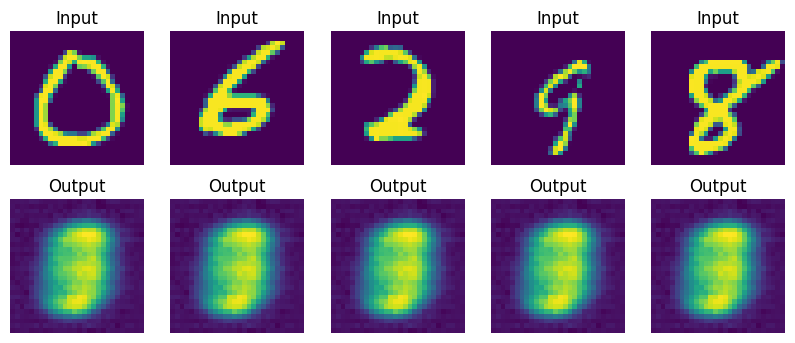

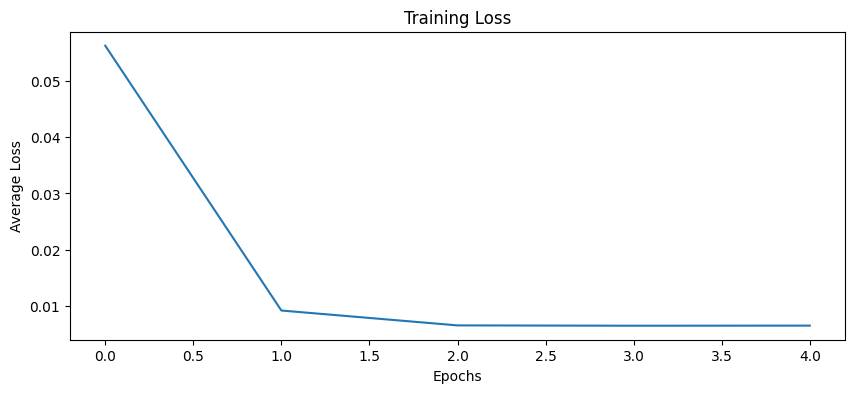

ValueError: too many values to unpack (expected 2)

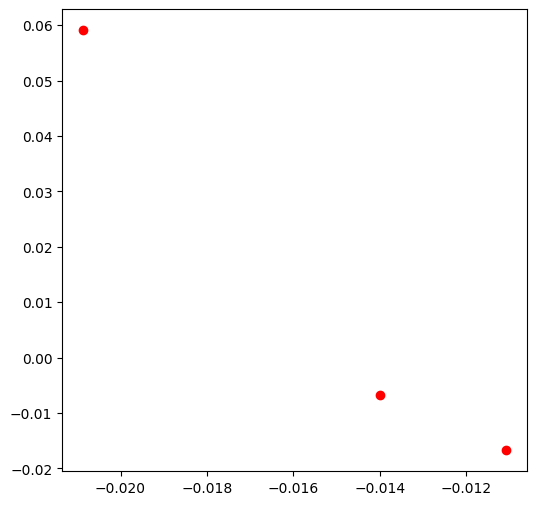

In [34]:
vqvae_model = VQVAE(in_ch = num_ch)
out_losses, final_model , final_codebook_vector = train_vqvae(vqvae_model, train_dataloader_multichannel, num_epochs=5)
visualize_resultss(final_model, test_dataloader_multichannel, out_losses)